# Foundations of Computational Economics #38

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

## Dynamic programming with continuous choice

<img src="_static/img/lecture.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/pAEm9cZd92Y](https://youtu.be/pAEm9cZd92Y)

Description: Optimization in Python. Consumption-savings model with continuous choice.

Goal: take continuous choice seriously and deal with it without discretization

- no discretization of choice variables  
- need to employ numerical optimizer to find optimal continuous choice in Bellman equation  
- optimization problem has to be solved for all points in the state space  


Implement the continuous version of Bellman operator for the stochastic consumption-savings model

### Consumption-savings problem (Deaton model)

$$
V(M)=\max_{0 \le c \le M}\big\{u(c)+\beta \mathbb{E}_{y} V\big(\underset{=M'}{\underbrace{R(M-c)+\tilde{y}}}\big)\big\}
$$

- discrete time, infinite horizon  
- one continuous choice of consumption $ 0 \le c \le M $  
- state space: consumable resources in the beginning of the period $ M $, discretized  
- income $ \tilde{y} $, follows log-normal distribution with $ \mu = 0 $ and $ \sigma $  

$$
V(M)=\max_{0 \le c \le M}\big\{u(c)+\beta \mathbb{E}_{y} V\big(\underset{=M'}{\underbrace{R(M-c)+\tilde{y}}}\big)\big\}
$$

- preferences are given by time separable utility $ u(c) = \log(c) $  
- discount factor $ \beta $  
- gross return on savings $ R $, fixed  

### Continuous (non-discretized) Bellman equation

Have to compute

$$
\max_{0 \le c \le M}\big\{u(c)+\beta \mathbb{E}_{y} V\big(R(M-c)+\tilde{y}\big)\big\} = \max_{0 \le c \le M} G(M,c)
$$

using numerical optimization algorithm

- constrained optimization (bounds on $ c $)  
- have to interpolate value function $ V(\cdot) $ for every evaluation of objective $ G(c) $  
- have to solve this optimization problem for **all possible values** $ M $  

#### Numerical optimization in Python

Optimization can be approached

1. **directly**, or through the lenses of analytic  
1. **first order conditions**, assuming the objective function is differentiable  


- FOC approach is equation solving, see video 13, 22, 23  
- here focus on optimization itself  


The two approaches are equivalent in terms of computational complexity, end even numerically

### Newton method as optimizer

$$
\max_{x \in \mathbb{R}} f(x) = -x^4 + 2.5x^2 + x + 2
$$

Solve the first order condition:

$$
\begin{eqnarray}
f'(x)=-4x^3 + 5x +1 &=& 0 \\
-4x(x^2-1) + x+1 &=& 0 \\
(x+1)(-4x^2+4x+1) &=& 0 \\
\big(x+1\big)\big(x-\frac{1}{2}-\frac{1}{\sqrt{2}}\big)\big(x-\frac{1}{2}+\frac{1}{\sqrt{2}}\big) &=& 0
\end{eqnarray}
$$

### Taylor series expansion of the equation

Let $ x' $ be an approximate solution of the equation $ g(x)=f'(x)=0 $

$$
g(x') = g(x) + g'(x)(x'-x) + \dots = 0
$$

$$
x' = x - g(x)/g'(x)
$$

Newton step towards $ x' $ from an approximate solution $ x_i $ at iteration $ i $ is then

$$
x_{i+1} = x_i - g(x_i)/g'(x_i) = x_i - f'(x_i)/f''(x_i)
$$

### Or use repeated quadratic approximations

Given approximate solution $ x_i $ at iteration $ i $, approximate function $ f(x) $ using first three terms of Taylor series

$$
\hat{f}(x) = f(x_i) + f'(x_i) (x-x_i) + \tfrac{1}{2} f''(x_i) (x-x_i)^2
$$

The maximum/minimum of this quadratic approximation is given by

$$
{\hat{f}}'(x) = f'(x_i) + f''(x_i) (x-x_i) = 0
$$

Leading to the Newton step

$$
x = x_{i+1} = x_i - f'(x_i)/f''(x_i)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def newton(fun,grad,x0,tol=1e-6,maxiter=100,callback=None):
    '''Newton method for solving equation f(x)=0
    with given tolerance and number of iterations.
    Callback function is invoked at each iteration if given.
    '''
    for i in range(maxiter):
        x1 = x0 - fun(x0)/grad(x0)
        err = abs(x1-x0)
        if callback != None: callback(err=err,x0=x0,x1=x1,iter=i)
        if err<tol: break
        x0 = x1
    else:
        raise RuntimeError('Failed to converge in %d iterations'%maxiter)
    return (x0+x1)/2

In [2]:
F = lambda x: -x**4+2.5*x**2+x+2 # main function
f = lambda x: -4*x**3+5*x+1      # FOC
g = lambda x: -12*x**2+5         # derivative of FOC

# make nice seriest of plots
a,b = -1.5,1.5  # upper and lower limits
xd = np.linspace(a,b,1000)  # x grid
ylim1 = [min(np.amin(f(xd))-1,0),max(np.amax(f(xd))+1,0)]
ylim2 = [min(np.amin(F(xd))-1,0),max(np.amax(F(xd))+1,0)]
print(ylim1,ylim2)
def plot_step(x0,x1,iter,**kwargs):
    plot_step.iter = iter+1
    if iter<10:
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
        ax1.set_title('FOC equation solver')
        ax1.plot(xd,f(xd),c='red')  # plot the function
        ax1.plot([a,b],[0,0],c='black')  # plot zero line
        ax1.plot([x0,x0],ylim1,c='grey') # plot x0
        l = lambda z: g(x0)*(z - x1)
        ax1.plot(xd,l(xd),c='green')  # plot the function
        ax1.set_ylim(bottom=ylim1[0],top=ylim1[1])
        ax2.set_title('Optimizer')
        ax2.plot(xd,F(xd),c='red')  # plot the function
        ax2.plot([x0,x0],ylim2,c='grey') # plot x0
        l = lambda z: F(x0)+f(x0)*(z-x0)+(g(x0)*(z-x0)**2)/2
        ax2.plot(xd,l(xd),c='green')  # plot the function
        ax2.plot([x1,x1],ylim2,c='grey') # plot x1
        ax2.set_ylim(bottom=ylim2[0],top=ylim2[1])
        ax1.set_ylabel('Iteration %d'%(iter+1))
        plt.show()

[-6.0, 8.0] [0, 5.726701321267283]


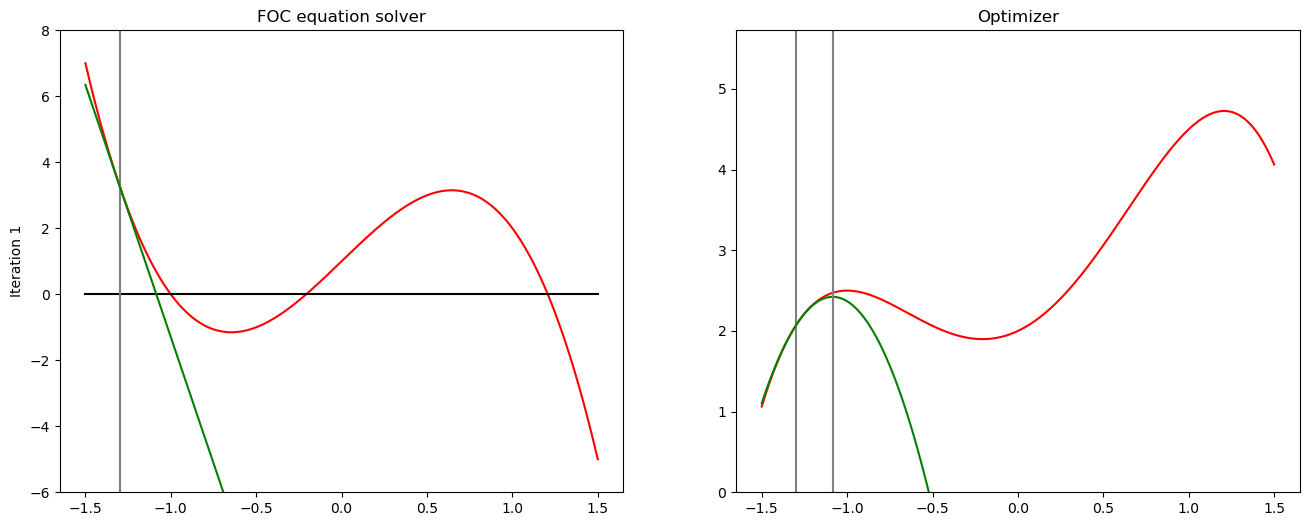

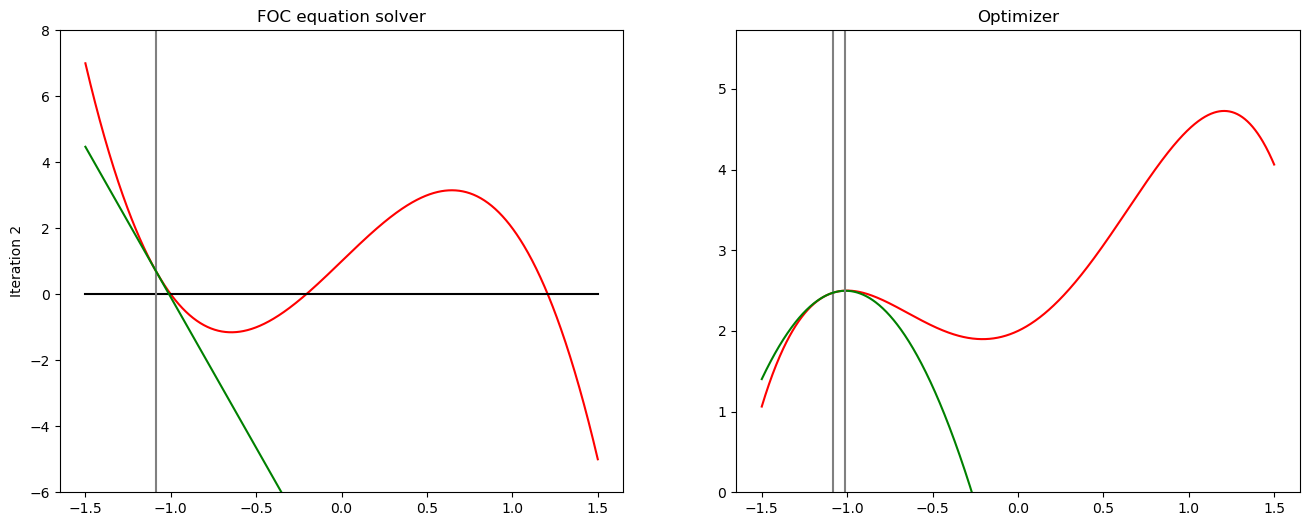

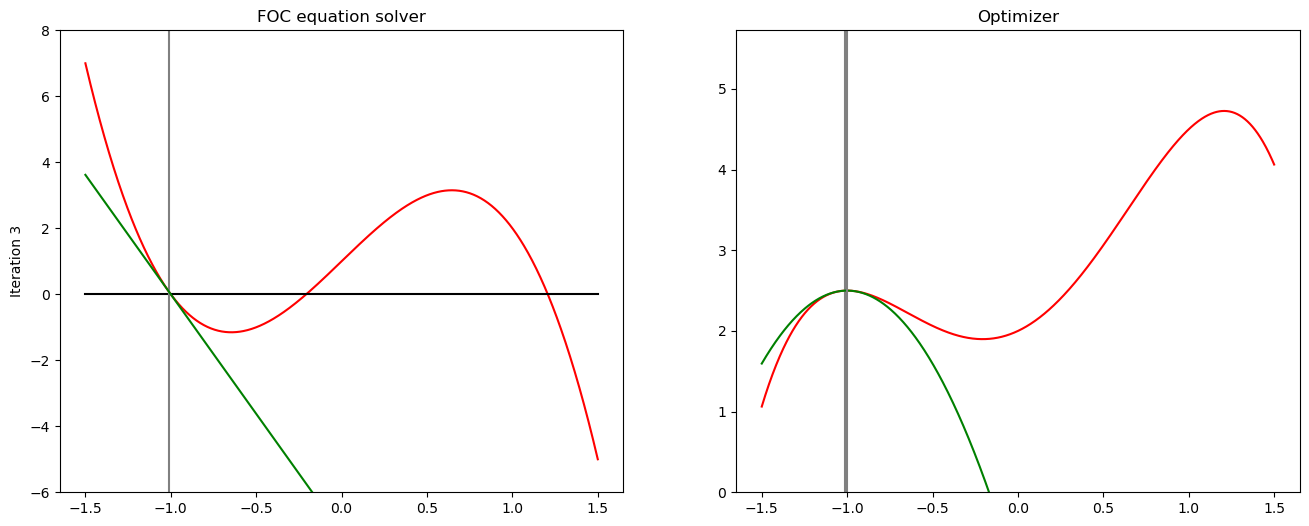

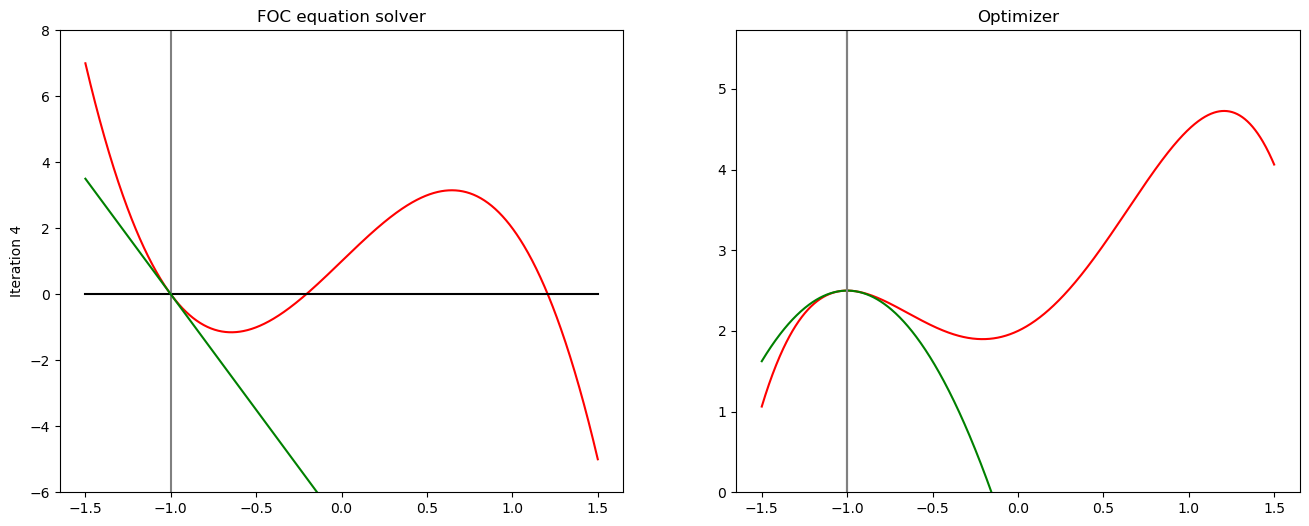

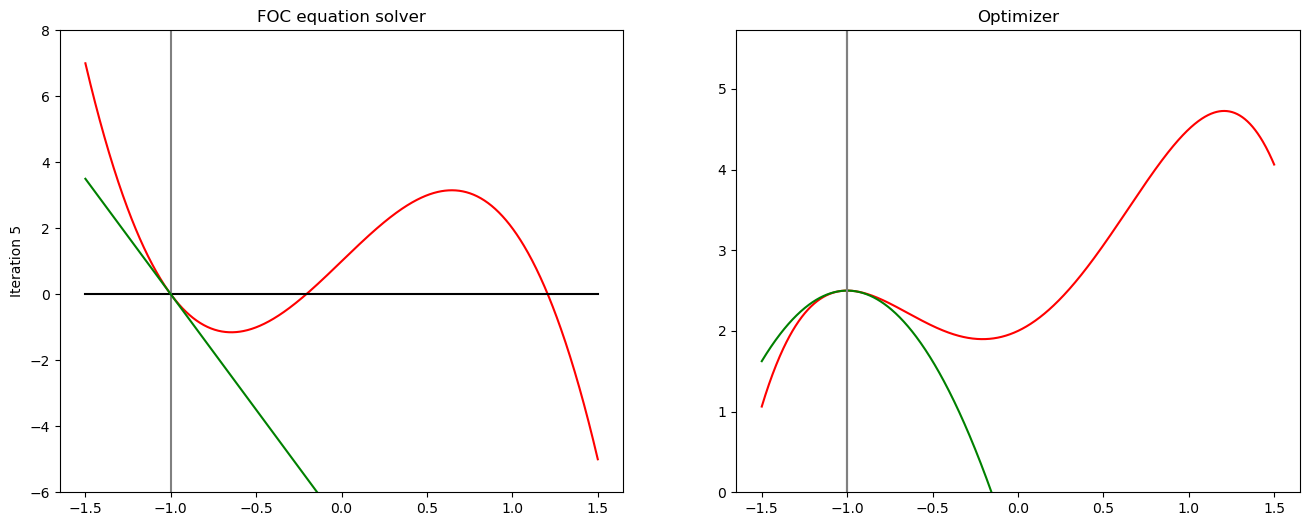

Converged in 5 iterations


In [3]:
newton(f,g,x0=-1.3,callback=plot_step) # 0.9, 0.42
print('Converged in %d iterations'%plot_step.iter)

### Multidimensional case

$$
\max_{x_1,\dots,x_n} F(x_1,\dots,x_n)
$$

- the Newton optimization method would work with multivariate function $ F(x_1,\dots,x_n) $, *gradient* vector $ \nabla F(x_1,\dots,x_n) $
  composed of partial derivatives, and a *Hessian* matrix $ \nabla^2 F(x_1,\dots,x_n) $ composed of second order partial derivatives of $ F(x_1,\dots,x_n) $  
- the FOC solver Newton method would work with vector-valued multivariate function $ G(x_1,\dots,x_n)=\nabla F(x_1,\dots,x_n) $,
  and a *Jacobian* matrix of first order partial derivatives of all of the outputs of the function $ G(x_1,\dots,x_n) $ with respect to all arguments  

### Newton step in multidimensional case

$$
x_{i+1} = x_i - \frac{F'(x_i)}{F''(x_i)} = x_i - \big( \nabla^2 F(x_i) \big)^{-1} \nabla F(x_i)
$$

- requires *inverting* the Hessian/Jacobian matrix  
- when analytic Hessian/Jacobian is not available, numerical differentiation can be used (yet slow and imprecise)  

### Quasi-Newton methods

**SciPy.optimize**

Main idea: replace Jacobian/Hessian with approximation. For example,
when costly to compute, and/or unavailable in analytic form.

- DFP (Davidon–Fletcher–Powell)  
- BFGS (Broyden–Fletcher–Goldfarb–Shanno)  
- SR1 (Symmetric rank-one)  
- BHHH (Berndt–Hall–Hall–Hausman) $ \leftarrow $ for statistical application and estimation!  

#### Broader view on the optimization methods

1. Line search methods  
  - Newton and Quasi-Newton  
  - Gradient descent  
1. Trust region methods  
  - Approximation of function in question in a ball around the current point  

1. Derivative free algorithms  
  - Nelder-Mead (simplex)  
  - Pattern search  
1. Global solution algorithms  
  - Simulation based  
  - Genetic algorithms  
1. **Poly-algorithms** Combinations of other algorithms  

### Global convergence of Newton method

Newton step: $ x_{i+1} = x_i + s_i $ where $ s_i $ is the *direction* of the step

$$
s_i = - \frac{f'(x_i)}{f''(x_i)} = - \big( \nabla^2 f(x_i) \big)^{-1} \nabla f(x_i)
$$

Newton method becomes globally convergent with a subproblem of choosing step size $ \tau $, such that

$$
x_{i+1} = x_i + \tau s_i
$$

**Globally convergent to local optimum**: converges from any starting value, but is not guaranteed to find global optimum

### Gradient descent

$$
x_{i+1} = x_i - \tau \nabla f(x_i)
$$

- $ \nabla f(x_i) $ is direction of the fastest change in the function
  value  
- As a greedy algorithm, can be much slower that Newton.  
- Finding optimal step size $ \tau $ is a separate one-dimensional optimization sub-problem  

#### Derivative-free methods

**Methods of last resort!**

- Grid search (`brute` in SciPy)  
- Nelder-Mead (“simplex”)  
- Pattern search (generalization of grid search)  
- Model specific (POUNDerS for min sum of squares)  

### Nelder-Mead

1. Initialize a simplex  
1. Update simplex based on function values  
  - Increase size of the simplex  
  - Reduce size of the simplex  
  - Reflect (flip) the simplex  
1. Iterate until convergence  

### Nelder-Mead

<img src="_static/img/nedlermead.png" style="">

### Trade-off with derivative free methods

Only local convergence. Anybody talking about global convergence with
derivative free methods is

- either assumes something about the problem (for example, concavity),  
- or is prepared to wait forever  


“An algorithm converges to the global minimum for any continuous
$ f $ if and only if the sequence of points visited by the algorithm
is dense in $ \Omega $.” Torn & Zilinskas book “Global Optimization”

### Global and simulation-based methods

Coincide with derivative-free methods $ \Rightarrow $ see above!

- Simulated annealing (`basinhopping, dual_annealing` in SciPy.optimize)  
- Particle swarms  
- Evolutionary algorithms  


Better idea: Multi-start + poly-algorithms

### Constrained optimization

Optimization in presence of constraints on the variables of the problem.

**SciPy.optimize**

- Constrained optimization by linear approximation (COBYLA)  
- Sequential Least SQuares Programming (SLSQP)  
- Trust region with constraints  

#### Solving for optimal consumption level in cake eating problem

<img src="_static/img/cake.png" style="width:128px;">

  
- Simple version of consumption-savings problem  
- No returns on savings $ R=1 $  
- No income $ y=0 $  
- What is not eaten in period $ t $ is left for the future $ M_{t+1}=M_t-c_t $  

### Bellman equation

$$
V(M_{t})=\max_{0 \le c_{t} \le M_t}\big\{u(c_{t})+\beta V(\underset{=M_{t}-c_{t}}{\underbrace{M_{t+1}}})\big\}
$$

Attack the optimization problem directly and run the optimizer to solve

$$
\max_{0 \le c \le M} \big\{u(c)+\beta V_{i-1}(M-c) \big \}
$$

### Thoughts on appropriate method

- For Newton we would need first and second derivatives of $ V_{i-1} $, which is
  itself only approximated on a grid, so no go..  
- The problem is bounded, so constrained optimization method is needed  
- **Bisections** should be considered  
- Other derivative free methods?  
- Quasi-Newton method with bounds?  

### Bounded optimization in Python

*Bounded optimization* is a kind of *constrained optimization* with simple
bounds on the variables
(like Robust Newton algorithm in video 25)

Will use **scipy.optimize.minimize_scalar(method=’bounded’)** which uses the
Brent method to find a local minimum.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import minimize_scalar
%matplotlib inline

class cake_continuous():
    '''Implementation of the cake eating problem with continuous choices.'''

    def __init__(self,beta=.9, Wbar=10, ngrid=50, maxiter_bellman=100,tol_bellman=1e-8):
        self.beta = beta    # Discount factor
        self.Wbar = Wbar    # Upper bound on cake size
        self.ngrid = ngrid  # Number of grid points for the size of cake
        self.epsilon = np.finfo(float).eps # smallest positive float number
        self.grid_state = np.linspace(self.epsilon,Wbar,ngrid) # grid for state space
        self.maxiter_bellman = maxiter_bellman # maximum iterations in Bellman solver
        self.tol_bellman = tol_bellman # tolerance in Bellman solver

    def bellman(self,V0):
        #Bellman operator, V0 is one-dim vector of values on grid

        def maximand(c,M,interf):
            '''Maximand of the Bellman equation'''
            Vnext = interf(M-c) # next period value at the size of cake in the next period
            V1 = np.log(c) + self.beta*Vnext
            return -V1 # negative because of minimization

        def findC(M,maximand,interf):
            '''Solves for optimal consumption for given cake size M and value function VF'''
            opt = {'maxiter':self.maxiter_bellman, 'xatol':self.tol_bellman}
            res = minimize_scalar(maximand,args=(M,interf),method='Bounded',bounds=[self.epsilon,M],options=opt)
            if res.success:
                return res.x # if converged successfully
            else:
                return M/2 # return some visibly wrong value

        # interpolation function for the current approximation of the vaulue function
        interfunc = interpolate.interp1d(self.grid_state,V0,kind='slinear',fill_value="extrapolate")
        # allocate space for the policy function
        c1=np.empty(self.ngrid,dtype='float')
        c1[0] = self.grid_state[0]/2 # skip the zero/eps point
        # loop over state space
        for i in range(1,self.ngrid):
            # find optimal consumption level for each point in the state space
            c1[i] = findC(self.grid_state[i],maximand,interfunc)
        # compute the value function corresponding to the computed policy
        V1 = - maximand(c1,self.grid_state,interfunc) # don't forget the negation!
        return V1, c1

    def solve(self, maxiter=1000, tol=1e-4, callback=None):
        '''Solves the model using successive approximations'''
        V0=np.log(self.grid_state) # on first iteration assume consuming everything
        for iter in range(maxiter):
            V1,c1=self.bellman(V0)
            if callback: callback(iter,self.grid_state,V1,c1) # callback for making plots
            if np.all(abs(V1-V0) < tol):
                break
            V0=V1
        else:  # when i went up to maxiter
            print('No convergence: maximum number of iterations achieved!')
        return V1,c1

    def solve_plot(self, maxiter=1000, tol=1e-4):
        '''Illustrate solution'''
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
        ax1.grid(b=True, which='both', color='0.65', linestyle='-')
        ax2.grid(b=True, which='both', color='0.65', linestyle='-')
        ax1.set_title('Value function convergence with VFI')
        ax2.set_title('Policy function convergence with VFI')
        ax1.set_xlabel('Cake size, W')
        ax2.set_xlabel('Cake size, W')
        ax1.set_ylabel('Value function')
        ax2.set_ylabel('Policy function')
        print('Iterations:',end=' ')
        def callback(iter,grid,v,c):
            print(iter,end=' ') # print iteration number
            ax1.plot(grid[1:],v[1:],color='k',alpha=0.25)
            ax2.plot(grid,c,color='k',alpha=0.25)
        V,c = self.solve(maxiter=maxiter,tol=tol,callback=callback)
        # add solutions
        ax1.plot(self.grid_state[1:],V[1:],color='r',linewidth=2.5)
        ax2.plot(self.grid_state,c,color='r',linewidth=2.5)
        plt.show()
        return V,c

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

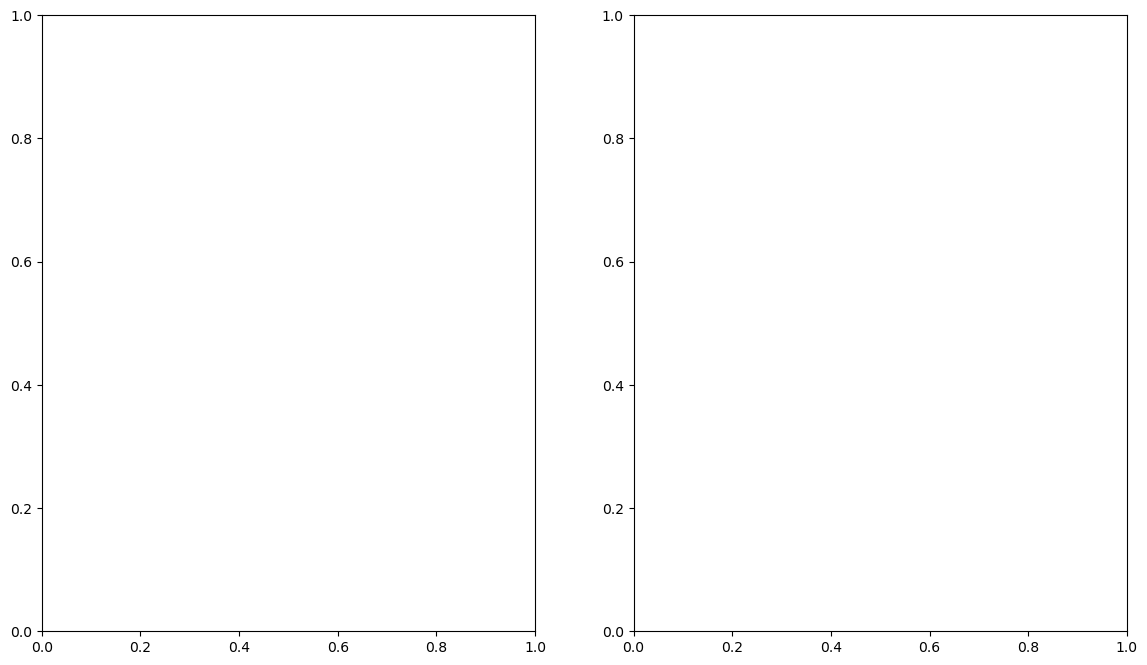

In [5]:
m3 = cake_continuous (beta=0.92,Wbar=10,ngrid=10,tol_bellman=1e-8)
V3,c3 = m3.solve_plot()

Iterations: 0 1 

2 3 4 5 

6 7 8 9 

10 11 12 13 

14 15 16 17 

18 19 20 21 

22 23 24 25 

26 27 28 29 

30 31 32 33 

34 35 36 37 

38 39 40 41 

42 43 44 45 

46 47 48 49 

50 51 52 53 54 

55 56 57 58 

59 60 61 

62 63 64 

65 66 67 68 

69 70 71 

72 73 74 

75 76 77 

78 79 80 81 

82 83 84 85 86 

87 88 89 

90 91 92 

93 94 95 96 

97 98 99 

100 101 102 103 

104 105 106 107 

108 109 110 111 

112 113 114 115 

116 117 118 119 

120 121 122 

123 124 125 

126 127 128 129 

130 131 132 133 

134 135 136 

137 138 139 

140 141 142 143 

144 145 146 

147 148 149 150 

151 152 153 

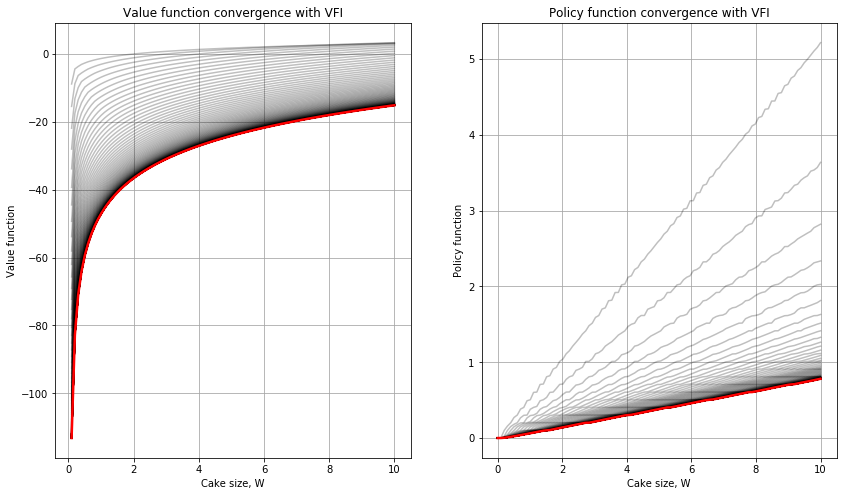

In [ ]:
m3 = cake_continuous (beta=0.92,Wbar=10,ngrid=100,tol_bellman=1e-4)
V3,c3 = m3.solve_plot()

### Conclusion

Dealing with continuous choice directly using numerical optimization:

- is **slow**, consider using lower level language or just in time complication in Python  
- more precise, but not ideal, requires additional technical parameters (tolerance and maxiter for within Bellman optimization)  


(Will come back to full blown stochastic consumption-savings model in the next practical video.)

#### Further learning resources

- Overview of SciPy optimize
  [https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)  
- Docs [https://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize)  
- Visualization of Nelder-Mead [https://www.youtube.com/watch?v=j2gcuRVbwR0](https://www.youtube.com/watch?v=j2gcuRVbwR0)  
- Brent’s method explained [https://www.youtube.com/watch?v=-bLSRiokgFk](https://www.youtube.com/watch?v=-bLSRiokgFk)  
- Many visualizations of Newton and other methods [https://www.youtube.com/user/oscarsveliz/videos](https://www.youtube.com/user/oscarsveliz/videos)  